In [1]:
import numpy as np
from scipy import special
from geometries import cubic_domain, spherical_domain, half_cubic_domain, broken_cubic_domain
from postprocess import relative_errZ,import_FOM_result
from dolfinx.fem import (form, Function, FunctionSpace, petsc)
import petsc4py
from petsc4py import PETSc
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm


In [2]:
from operators_POO import Mesh, B1p, Loading, Simulation

geometry1 = 'cubic'
geometry2 = 'small'
geometry  = geometry1 + '_'+ geometry2

if   geometry2 == 'small':
    side_box = 0.11
    lc       = 8e-3
elif geometry2 == 'large':
    side_box = 0.40
    lc       = 2e-2
else :
    print("Enter your own side_box and mesh size in the code")
    side_box = 0.11
    lc       = 8e-3 #Typical mesh size : Small case : 8e-3 Large case : 2e-3

radius   = 0.1

rho0 = 1.21
c0   = 343.8

freqvec = np.arange(80, 2001, 20)

In [3]:
mesh_    = Mesh(1, side_box, radius, lc, cubic_domain)
_, ds, _ = mesh_.integral_mesure()


loading        = Loading(mesh_)
list_coeff_F_j = loading.deriv_coeff_F(0)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [100%] Meshing curve 15 (Circle)
Info    : Done meshing 1D (Wall 0.00278425s, CPU 0.003562s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 5 (Plan

In [4]:
from operators_POO import B1p
ope1  = B1p(mesh_)
simu1 = Simulation(mesh_, ope1, loading)

In [5]:
from operators_POO import store_results, import_frequency_sweep
from_data_b1p = True
if from_data_b1p:
    s1 = 'FOM_b1p'
    s = s1 + '_' + geometry
    freqvec, PavFOM1 = import_frequency_sweep(s)
else :
    PavFOM1 = simu1.FOM(freqvec)
    s1 = 'FOM_b1p'
    s = s1 + '_' + geometry
    store_results(s, freqvec, PavFOM1)

In [6]:
from operators_POO import SVD_ortho
if False :
    N    = 15
    f_0  = 1000
    t1   = time()
    Vn   = simu1.wcawe(N, f_0)
    t2   = time()
    print(f'WCAWE CPU time  : {t2 -t1}')
    
    Vn = SVD_ortho(Vn)
    t3 = time()
    print(f'SVD CPU time  : {t3 -t2}')
    
    PavWCAWE = simu1.moment_matching_MOR(Vn, freqvec)
    t4       = time()
    print(f'Whole CPU time  : {t4 -t1}')


In [7]:
list_N1 = [10]
list_freq1 = [1000]
t1   = time()
Vn   = simu1.merged_WCAWE(list_N1, list_freq1)
t2   = time()
print(f'WCAWE CPU time  : {t2 -t1}')
#Vn = SVD_ortho(Vn)
t3 = time()
print(f'SVD CPU time  : {t3 -t2}')
PavWCAWE1 = simu1.moment_matching_MOR(Vn, freqvec)
t4       = time()
print(f'Whole CPU time  : {t4 -t1}')

WCAWE CPU time  : 1.5845792293548584
SVD CPU time  : 0.00027632713317871094


100%|███████████████████████████████████████████| 97/97 [00:03<00:00, 27.38it/s]

Whole CPU time  : 5.139233589172363


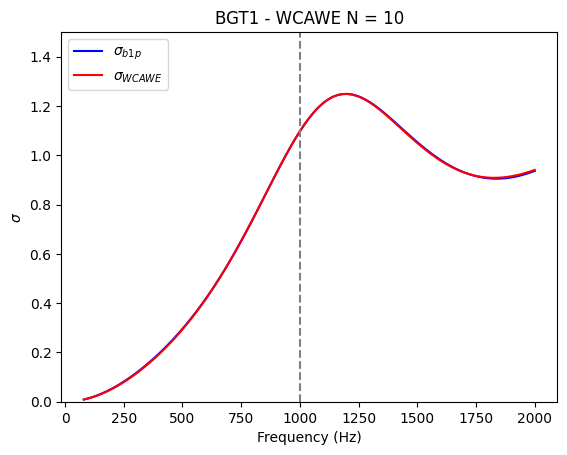

In [8]:
fig, ax = plt.subplots()
simu1.plot_radiation_factor(ax, freqvec, PavFOM1, s = 'FOM_b1p')
#simu1.plot_radiation_factor(ax, freqvec, PavWCAWE, s = 'WCAWE')
simu1.plot_radiation_factor(ax, freqvec, PavWCAWE1, s = 'WCAWE')
for i in range(len(list_freq1)):
    ax.plot([list_freq1[i] for _ in range(100)], np.linspace(0, 1.5, 100), c = 'grey', linestyle='--' )
ax.set_ylim(0, 1.5)
ax.set_title(f"BGT1 - WCAWE N = {list_N1[0]}")
plt.savefig(f'WCAWE_curves/BGT1_N_{list_N1[0]}')

In [9]:
from operators_POO import B2p
mesh_.set_deg(2)
ope2           = B2p(mesh_)

loading        = Loading(mesh_)
list_coeff_F_j = loading.deriv_coeff_F(0)

simu2 = Simulation(mesh_, ope2, loading)

In [10]:
from_data_b2p = True

if from_data_b2p:
    s2 = 'FOM_b2p'
    s = s2 + '_' + geometry
    freqvec, PavFOM2 = import_frequency_sweep(s)
else :
    PavFOM2 = simu2.FOM(freqvec)
    s2 = 'FOM_b2p'
    s = s2 + '_' + geometry
    store_results(s, freqvec, PavFOM2)

In [11]:
if False:
    N    = 20
    f_0  = 1000
    t1   = time()
    Vn   = simu2.wcawe(N, f_0)
    t2   = time()
    print(f'WCAWE CPU time  : {t2 -t1}')
    
    Vn = SVD_ortho(Vn)
    t3 = time()
    print(f'SVD CPU time  : {t3 -t2}')
    
    PavWCAWE = simu2.moment_matching_MOR(Vn, freqvec)
    t4       = time()
    print(f'Whole CPU time  : {t4 -t1}')


In [12]:
list_N2 = [5, 5]
list_freq2 = [750, 1500]
t1   = time()
Vn   = simu2.merged_WCAWE(list_N2, list_freq2)
t2   = time()
print(f'WCAWE CPU time  : {t2 -t1}')

#Vn = SVD_ortho(Vn)
t3 = time()
print(f'SVD CPU time  : {t3 -t2}')
PavWCAWE2 = simu2.moment_matching_MOR(Vn, freqvec)
t4       = time()
print(f'Whole CPU time  : {t4 -t1}')


WCAWE CPU time  : 41.747538805007935
SVD CPU time  : 0.00018668174743652344


100%|███████████████████████████████████████████| 97/97 [00:13<00:00,  7.04it/s]

Whole CPU time  : 55.52704071998596


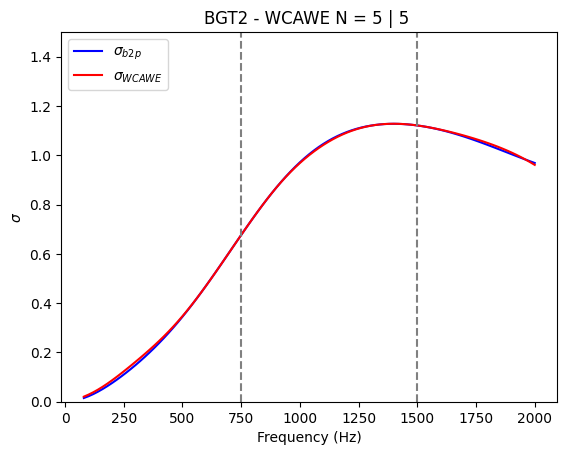

In [13]:
fig, ax = plt.subplots()
simu2.plot_radiation_factor(ax, freqvec, PavFOM2, s = 'FOM_b2p')
#simu2.plot_radiation_factor(ax, freqvec, PavWCAWE, s = 'WCAWE')
simu2.plot_radiation_factor(ax, freqvec, PavWCAWE2, s = 'WCAWE')
for i in range(len(list_freq2)):
    ax.plot([list_freq2[i] for _ in range(100)], np.linspace(0, 1.5, 100), c = 'grey', linestyle='--' )
ax.set_ylim(0, 1.5)
ax.set_title(f"BGT2 - WCAWE N = {list_N2[0]} | {list_N2[1]} ")
plt.savefig(f'WCAWE_curves/BGT2_N_{list_N2[0]}_{list_N2[1]}')